In [41]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv


BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> </span> Preprocessing

In [42]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')
    
    boxes = []
    classes = []
    
    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
        
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
        
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)
    
            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    
    return img_path, classes, boxes


# a function for creating file paths list 
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


class_ids = ['Acne']
class_mapping = {0: 'Acne'}

In [43]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):
    
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)
    
    image_paths = []
    bbox = []
    classes = []
    
    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)
        
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    
    return image_paths, classes, bbox

In [44]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files('/home/alex/salutis/data/train/images', 
                                                              '/home/alex/salutis/data/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('/home/alex/salutis/data/valid/images',
                                                             '/home/alex/salutis/data/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/home/alex/salutis/data/testV2/images',
                                                          '/home/alex/salutis/data/testV2/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [45]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) 
    
    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }
    
    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [59]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [32]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

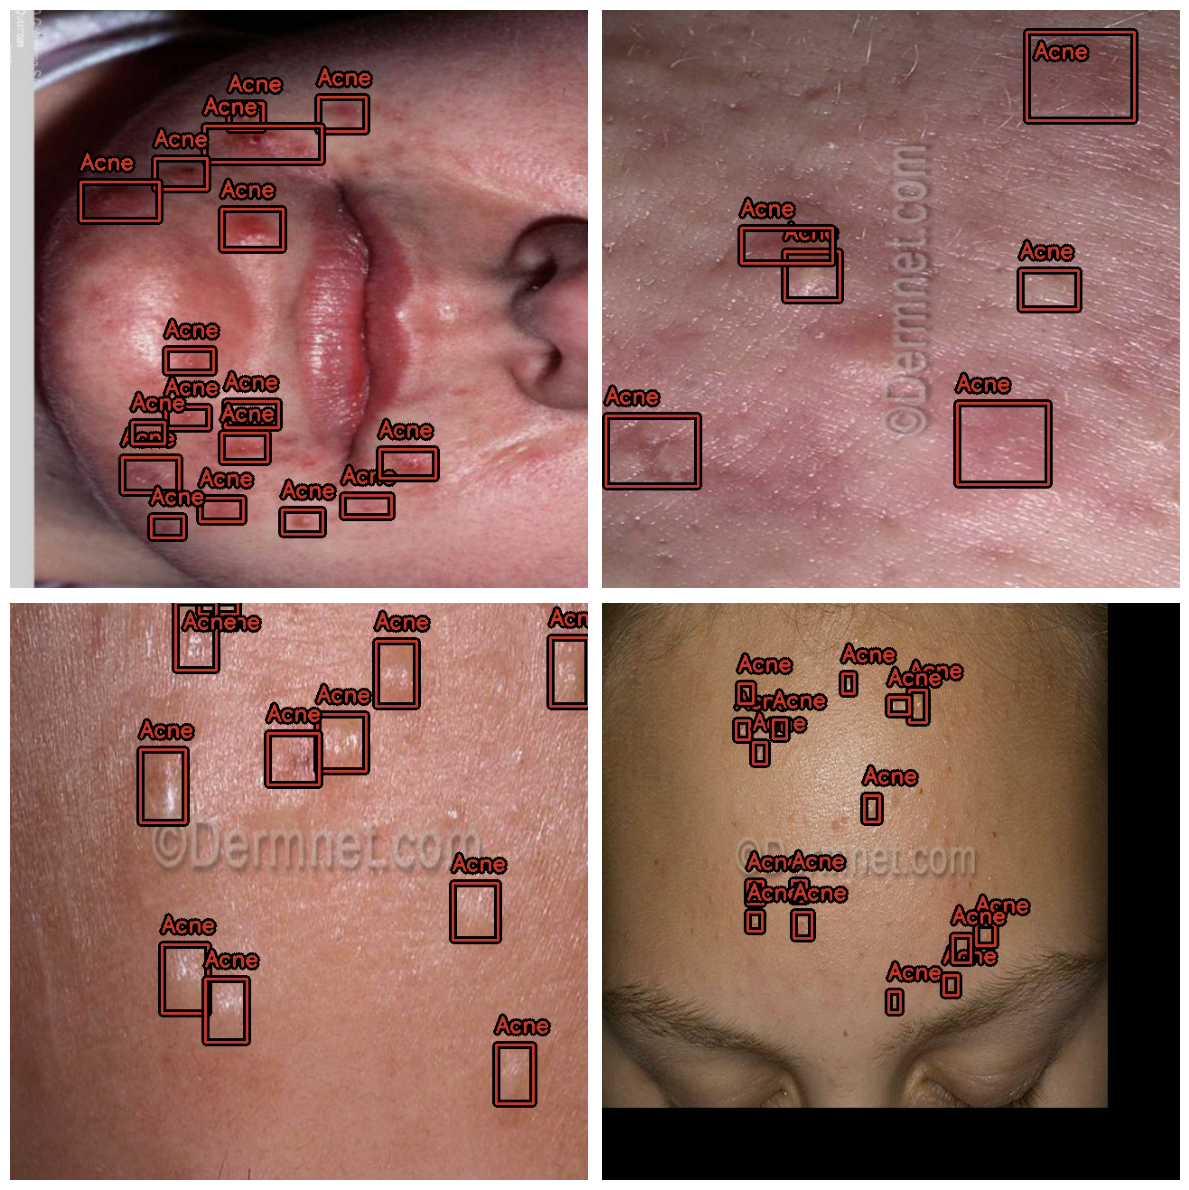

In [47]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [48]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [49]:
# creating yolo backbone

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone", include_rescaling = True)
    
    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                                  bounding_box_format = "xyxy", backbone = backbone, fpn_depth = 5)

    # optimizer = AdamW(learning_rate=0.0007, weight_decay=0.0009, global_clipnorm = 10.0)
    # my_callbacks = [ModelCheckpoint('models/V2/yolo_acne_detection.weights.h5', monitor = 'val_loss',save_best_only = True, save_weights_only = True),
    #                 ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=8, verbose=0, min_delta=0.01),#factor has been changed from 0.01 to 0.1 same as min_delta
    #                 EarlyStopping(monitor='val_loss', patience=20)]
    

    # YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

# <span style="color:#e74c3c;"> Training </span> 

In [ ]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 60, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


NameError: name 'hist' is not defined

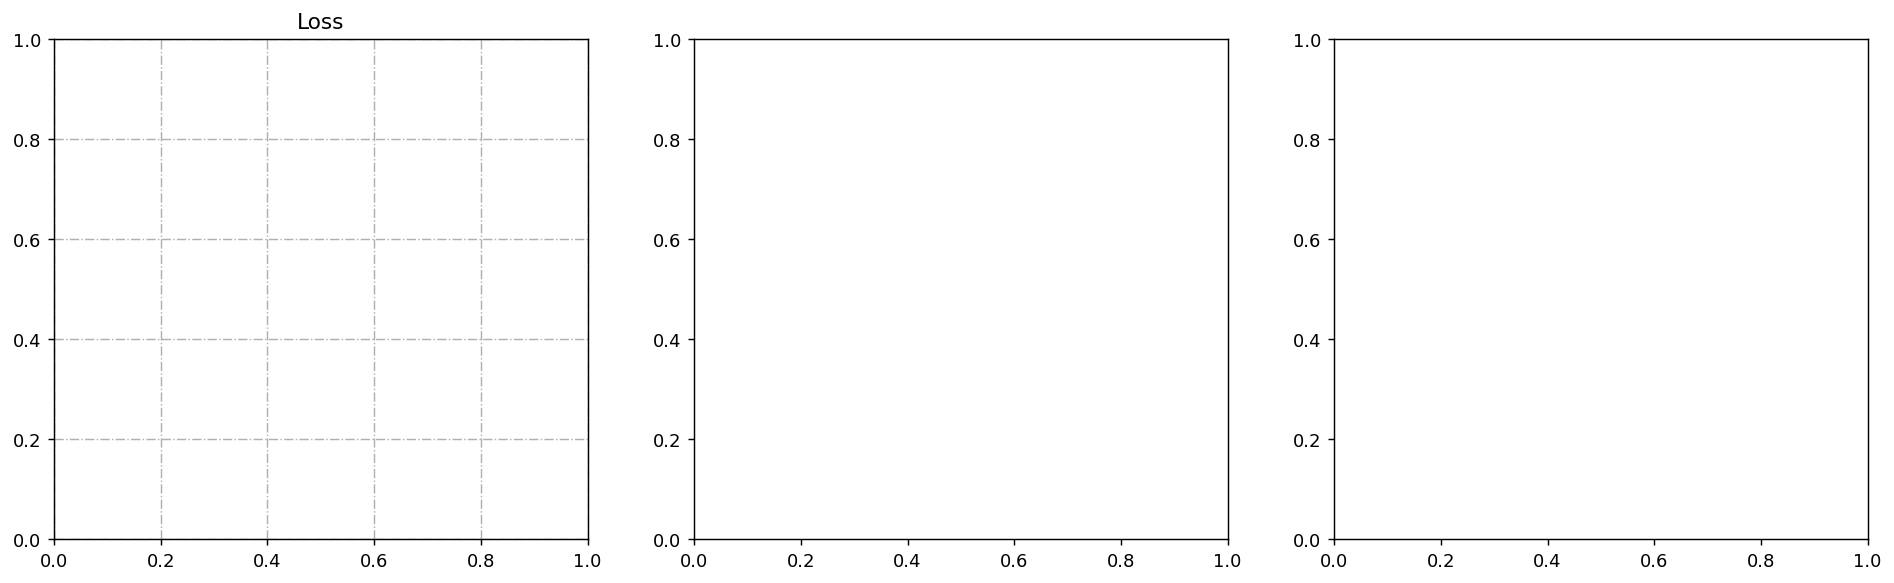

In [12]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][5:])
axs[0].plot(hist.history['val_loss'][5:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][5:])
axs[2].plot(hist.history['val_class_loss'][5:])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
YOLOV8_model.evaluate(test_dataset)

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def compare_predictions(model, dataset, bounding_box_format):
    dataset = dataset.shuffle(buffer_size=1024)
    
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images, verbose = 0)

    fig, axs = plt.subplots(2, 4, figsize=(15, 10))

    for i, ax in enumerate(axs.flat):
        image = images[i]
        true_boxes = y_true[i]
        pred_boxes = y_pred[i]

        ax.imshow(image)

        if len(true_boxes) > 0:
            for box in true_boxes:
                rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        if len(pred_boxes) > 0:
            for box in pred_boxes:
                rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
        

        ax.set_title(f'Image {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [60]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    # Make the images appear in random order
    dataset = dataset.shuffle(buffer_size=1024)

    # Create a new iterator for the dataset
    dataset_iter = iter(dataset.take(1))

    images, y_true = next(dataset_iter)
    y_pred = model.predict(images, verbose = 0)
    # y_pred = keras_cv.bounding_box.to_ragged(y_pred) # ragged tensor

    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=4,
        show=True,
        class_mapping=class_mapping,
    )

2024-04-28 14:44:30.034015: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-04-28 14:44:30.044650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


IndexError: index 1 is out of bounds for axis 0 with size 1

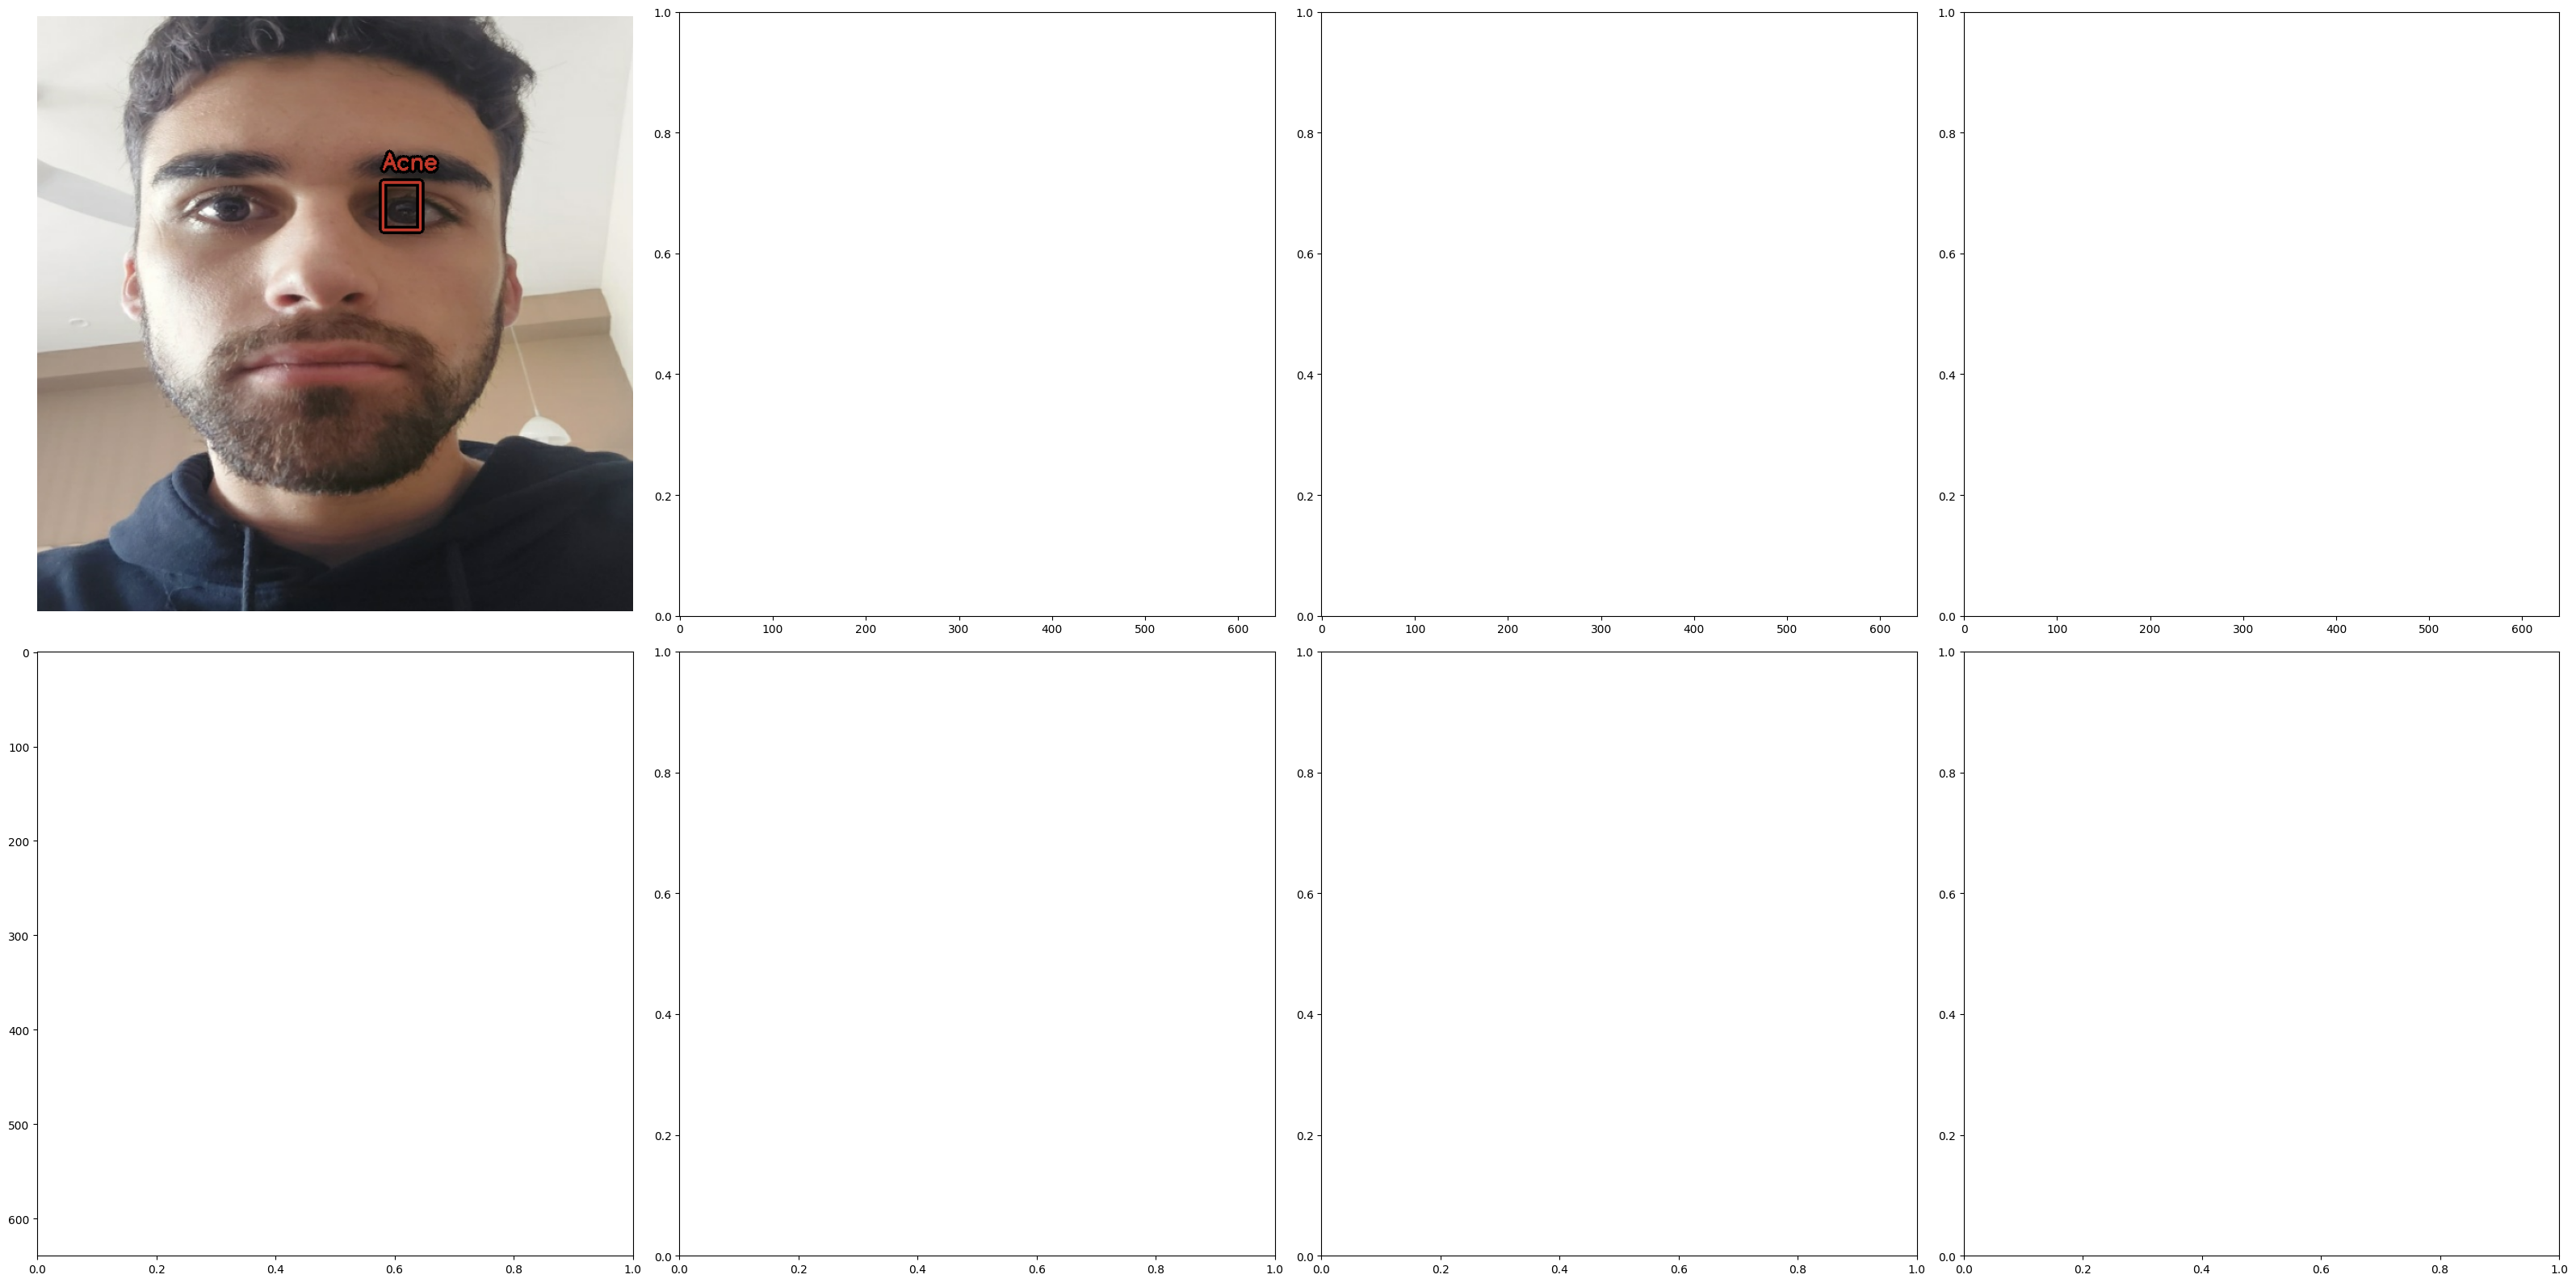

In [61]:
# red -> ground true
# yellow -> prediction

YOLOV8_model.load_weights('/home/alex/salutis/models/V3/yolo_acne_detection.h5')

visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")
# compare_predictions(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")